### 2:  Warmup - life without a CLT

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def monte_carlo(alpha,num_samples, sample_generator, g_evaluator, cumsum=False):
    """Perform Monte Carlo sampling
    
    Inputs
    ------
    num_samples: integer, number of samples
    sample_generator: A function that generates samples with signature sample_generator(nsamples)
    g_evaluator: a function that takes as inputs the samples and outputs the evaluations. 
                 The outputs can be any dimension, however the first dimension should have size *num_samples*
    cumsum: Boolean, an option to return estimators of all sample sizes up to num_samples
                 
    Returns
    -------
    A Monte Carlo estimator of the mean, samples, and evaluations
    """
    samples = sample_generator(alpha,num_samples)
    evaluations = g_evaluator(samples)
    if cumsum is False:
        estimate =  np.sum(evaluations, axis=0) / float(num_samples)
    else:        
        estimate = np.cumsum(evaluations, axis=0) / np.arange(1,num_samples+1, dtype=np.float)
        
    return estimate, samples, evaluations

In [3]:
def pareto_rv(alpha,xinput):
    p = [alpha/( x**(alpha+1) ) if x>=1 else 0 for x in xinput]
    return p

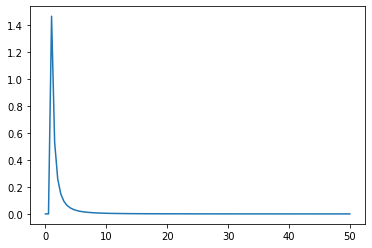

In [4]:
alpha = 3/2
x = np.linspace(0,50,100)
y = pareto_rv(alpha,x)
plt.plot(x,y)

#### CDF of pareto is given by 
\begin{equation}
    CDF = \int_1^x \frac{\alpha}{x^{\alpha+1}} = 1 - \frac{1}{x^{\alpha}}
\end{equation}
Now creating a pareto sampler with Inverse CDF sampler

In [5]:
np.random.seed(10)

def pareto_cdf(alpha,xinput):
    return 1 - 1/xinput**alpha

3/2

In [6]:
alpha = 3/2
g = lambda x: x # identity function
num_trials = 500
num_samples = 10000
estimator_vals = np.zeros((num_trials, num_samples))
for trial in range(num_trials):
    estimator_vals[trial, :], _, _ = monte_carlo(alpha,num_samples, pareto_sampler, g, cumsum=True)
#     print("one trial: ", estimator_vals[trial, :])

### Plotting

estimates (500, 10000)


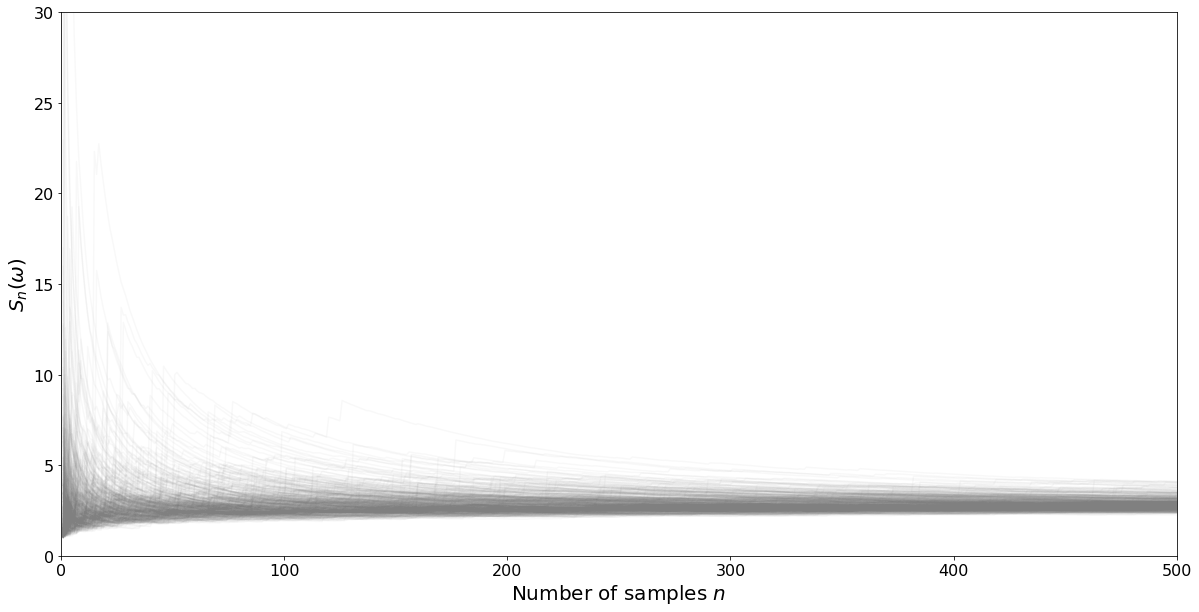

In [9]:
print("estimates",np.shape(estimator_vals))
plt.figure(figsize=(20,10))
plt.plot(np.arange(1, num_samples+1), estimator_vals.T, color='grey', alpha=0.05)
plt.ylabel(r'$S_n(\omega)$', fontsize=20)
plt.xlabel(r'Number of samples $n$', fontsize=20)
plt.xticks(fontsize=16)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
plt.yticks(fontsize=16)
plt.xlim([0, 500])
plt.ylim([0, 30])
plt.show()

In [10]:
np.shape(np.arange(1, num_samples+1))

(10000,)

### Getting mean from all trials. actual mean = 3.0

In [7]:
print(estimator_vals[:,-1])

[2.87234107 2.83648657 2.93834297 2.97740059 2.78186398 2.71981321
 2.86328962 2.89007172 2.90801394 2.81936072 2.8784459  2.81255978
 2.93364583 2.97087859 2.95357809 2.97679929 2.89627136 2.88923639
 2.95908211 2.85081649 2.78281459 2.88956822 2.89982427 2.88455821
 2.92663881 2.82148698 2.84943575 2.80657022 2.83475203 2.89308122
 2.95049074 2.84933545 2.86081107 2.89766608 2.78385252 2.9128019
 2.9904351  2.91756989 2.74029837 2.88010958 2.86625421 2.88426779
 2.78349872 2.90881036 2.84091574 2.79927826 2.97870349 2.88612609
 2.93799516 2.85103456 2.89306575 2.90674797 2.92637333 2.9102405
 2.77335395 2.70120382 2.8391807  2.8490066  2.75893221 2.87455765
 2.91120608 2.81002833 2.97193848 2.7361691  2.93060041 2.83653397
 2.83547808 2.7768934  2.91603046 2.78361    2.88504624 2.86186147
 2.76974615 2.83483736 2.78817191 2.77653012 2.77615387 2.86990044
 2.92947715 2.90727641 2.73386669 2.87369338 2.89905082 3.00528748
 2.75490125 2.90846405 2.72222241 2.89407773 2.81606629 2.927924

In [7]:
print("Mean is ",np.mean(estimator_vals[:,-1]))

Mean is  2.8735793153731515


### Evaluate convergence properties
Copying functions from lecture notebooks on weak_vs_strong_convergence

In [108]:
def estimate_probability_prob(sample_path_errs, epsilon, n):
    """ Estimate the probability of the event related to convergence in probability
    
    sample_path_errs: (Npaths, Nsamples_per_path) array of errors of each path
    epsilon: float, target error region
    n: positive integer
    """
    
    Npaths, Nsamples_per_path = sample_path_errs.shape
    estimate = np.sum(sample_path_errs[:, n-1] > epsilon) / float(Npaths) #n-1 because indexing by zero
    return estimate

def estimate_probability_as(sample_path_errs, epsilon, n):
    """ Estimate the probability of the event related to convergence almost surely
    
    sample_path_errs: (Npaths, Nsamples_per_path) array of errors of each path
    epsilon: float, target error region
    n: positive integer
    
    Note
    ----
    This function is a bit inefficient, it would be better if n could be a list of variables so that we can reuse
    the calculations
    """
    
    Npaths, Nsamples_per_path = sample_path_errs.shape
    # Note the difference from in probability ---- we are looking into the future
    # We are looking if any value in the path satisfies the error condition
    paths_satisfy_condition = np.any(sample_path_errs[:, n-1:] > epsilon, axis=1)
    estimate = np.sum(paths_satisfy_condition) / float(Npaths)
    return estimate

In [114]:
epsilon = 0.1
n = np.arange(1, num_samples+1)
prob_as = np.zeros((n.shape[0])) # probability almost surely
prob_p = np.zeros((n.shape[0]))
for ii, nn in enumerate(n):
    # we take absolute values because the true answer is 0
    prob_as[ii] = estimate_probability_as(np.abs(estimator_vals-3.0), epsilon, nn) 
    prob_p[ii] = estimate_probability_prob(np.abs(estimator_vals-3.0), epsilon, nn)

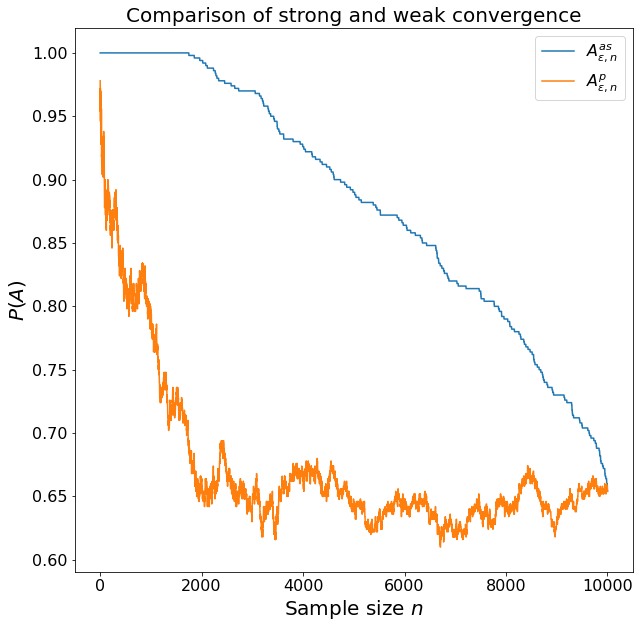

In [115]:
plt.figure(figsize=(10,10))
plt.plot(n, prob_as, label=r'$A_{\epsilon, n}^{as}$')
plt.plot(n, prob_p, label=r'$A_{\epsilon, n}^{p}$')
plt.title('Comparison of strong and weak convergence', fontsize=20)
plt.ylabel(r'$P(A)$', fontsize=20)
plt.xlabel(r'Sample size $n$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()